## **Location-based Analysis**

Welcome to this Colab where you will get a informative analysis of individual countries and locations at a fixed point of time. Here, you can see how each country has handled the pandemic so far, compared to other countries. We also get an insight into how different parts of the world - such as continents - are doing their job to fight the virus.

To start, we imported a great number of useful libraries to assist us with data processing, calculating and visualization.

In [ ]:
!pip install geopandas
!pip install pycountry
!pip install chardet

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import matplotlib
import matplotlib.dates as mdates
from datetime import datetime
import seaborn as sns
import numpy as np
from scipy.stats import linregress
from statistics import mean
import geopandas as gpd
import pycountry 
from statsmodels.tsa.seasonal import seasonal_decompose
import sys
from scipy.signal import find_peaks
import statistics
from google.colab import drive
from tabulate import tabulate
import string
from scipy.stats import norm
import matplotlib.mlab as mlab
import io

In [ ]:
%%shell
gdown -q --id 1LVId24T-ZXO5PxD721BY_k8ZdFVkHXD0
gdown -q --id 1fTVkZrRIOVbBjQf0kVH8Radl1Oi37al4
#gdown -q --id 12mDPTZD2D1Uxb9es0Z4MjgyZrhOpfqoI
#gdown -q --id 1GFvqs9jdQtflBQX8yjdGo1ff83Yd9CAy
echo "Preparation: Done"

Preparation: Done


## The time point

This is the exact time point that we will perform most of our comparisons. Default time is the last day of the time period mentioned in the assignment.

In [ ]:
date = "2021-05-31"

## Getting data from GitHub

For this colab, we used two files from the same source, OWID, and a file from opendevelopmentmekong.net. The data has been processed to suit our purest and noblest dream.

In [ ]:
data_covid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv", parse_dates=['date'])
data_vaccinations_by_age_group = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations-by-age-group.csv", parse_dates=['date'])
data_vaccinations_by_manufacturer = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations-by-manufacturer.csv", parse_dates=['date'])

data_countries = data_covid[data_covid["continent"].notna()].loc[data_covid["date"] == date].set_index("iso_code")
data_continents = data_covid[data_covid["continent"].isna()].loc[data_covid["date"] == date]

data_vaccinations_by_age_group = data_vaccinations_by_age_group[(data_vaccinations_by_age_group["date"] <= date) & (data_vaccinations_by_age_group["date"] >= "2021-05-28")]
data_vaccinations_by_manufacturer = data_vaccinations_by_manufacturer[data_vaccinations_by_manufacturer["date"] <= date]

provinces = gpd.read_file('province data.geojson')
data = pd.read_excel('province data.xlsx')
df_vn_en = pd.read_csv("https://data.vietnam.opendevelopmentmekong.net/en/dataset/100d98c8-4ffc-4b5b-b2a5-c6b71d2eff66/resource/d2967df9-3ef2-4d86-ad21-c14becf043fc/download/covid19-provinces_vn_vn.csv", encoding="utf-16", delimiter='\t')
df_g = pd.read_csv("https://data.vietnam.opendevelopmentmekong.net/en/dataset/100d98c8-4ffc-4b5b-b2a5-c6b71d2eff66/resource/d2967df9-3ef2-4d86-ad21-c14becf043fc/download/covid19-provinces_vn_vn.csv", encoding="utf-16", delimiter='\t')
df = df_g.merge(data, left_on="Province", right_on="province", how="outer")

## The correlation matrix

This is the correlation matrix of out main dataset. The matrix contained the relation between variables, thus gave us some handy information about the relationship of the variables. 

A heatmap has been provided as a mean of visualization. The lighter the color, the more positive the relationship is and vice versa.

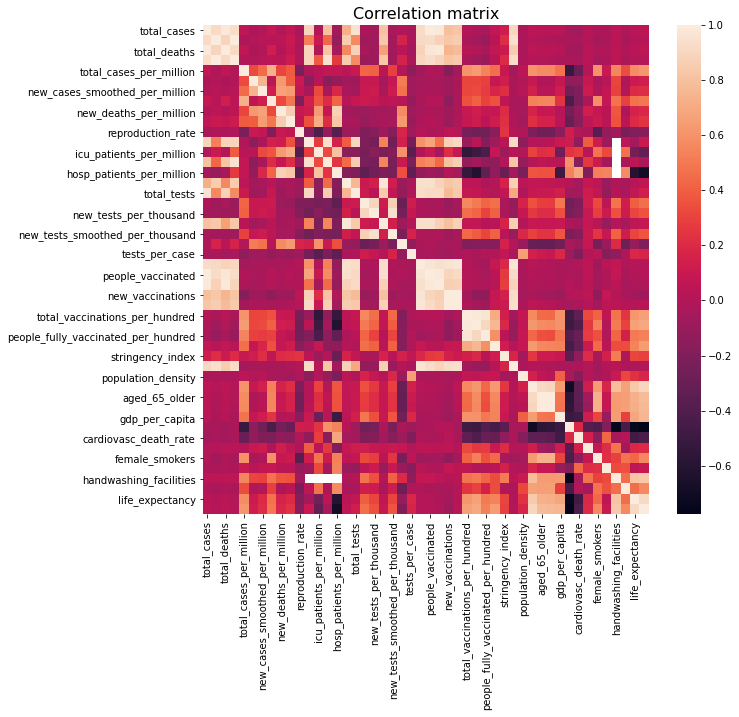

In [ ]:
data = data_covid.loc[data_covid["date"] == date].drop(["new_cases_smoothed", "new_deaths_smoothed", "excess_mortality", "weekly_icu_admissions", "weekly_icu_admissions_per_million", "weekly_hosp_admissions", "weekly_hosp_admissions_per_million"], axis=1)
data.reset_index()
data.drop(["date"], axis = 1)
data.set_index("iso_code", inplace = True)
corr_matrix = data.corr()

fig, ax = plt.subplots(figsize=(10,9))  
sns.heatmap(corr_matrix)
plt.title("Correlation matrix", fontsize=16)
plt.show()

## Variables with positive correlation coefficient

Below are three graphs with the correlation coefficient greater than 0.5. This indicated a strong relationship between those variables. From these graphs, we can conclude that countries with higher GDP per capita tend to have more people vaccinated, or countries with high HDI usually have a bigger p

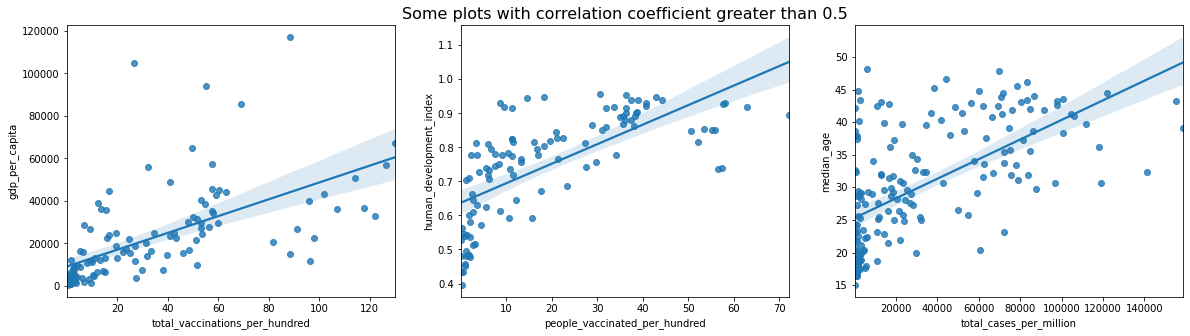

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize = (20, 5))
sns.regplot(data["total_vaccinations_per_hundred"], data["gdp_per_capita"], ax=axs[0])
sns.regplot(data["people_vaccinated_per_hundred"], data["human_development_index"], ax=axs[1]).set_title('Some plots with correlation coefficient greater than 0.5', fontsize = 16)
sns.regplot(data["total_cases_per_million"], data["median_age"], ax=axs[2])

## Variables with negative correlation coefficient

Below are three graphs with the correlation coefficient smaller than 0.5. This indicated a strong reversed (??) relationship between those variables.

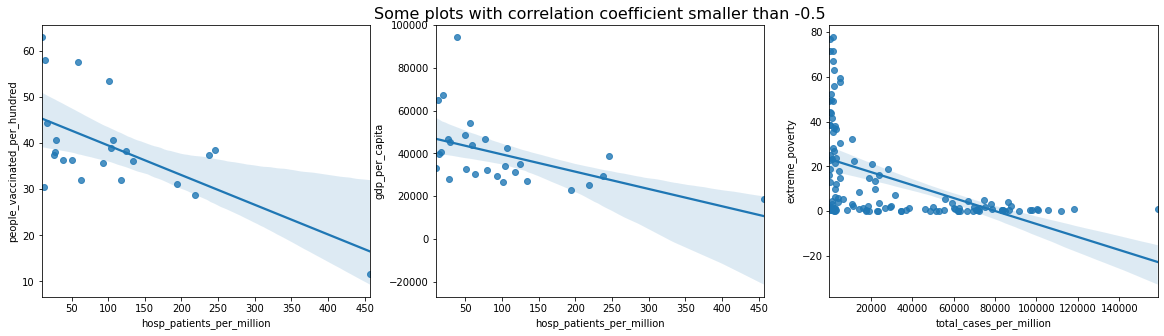

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize = (20, 5))
sns.regplot(data["hosp_patients_per_million"], data["people_vaccinated_per_hundred"], ax=axs[0])
sns.regplot(data["hosp_patients_per_million"], data["gdp_per_capita"], ax=axs[1]).set_title('Some plots with correlation coefficient smaller than -0.5', fontsize = 16)
sns.regplot(data["total_cases_per_million"], data["extreme_poverty"], ax=axs[2])

## Vaccination rates and country income levels

The next graph shows us how vaccination rates, income levels and population sizes related to each other. The graph has the x axis as the percentage of people vaccinated, the y axis as the GDP per capita, and the circles' size as the population size.

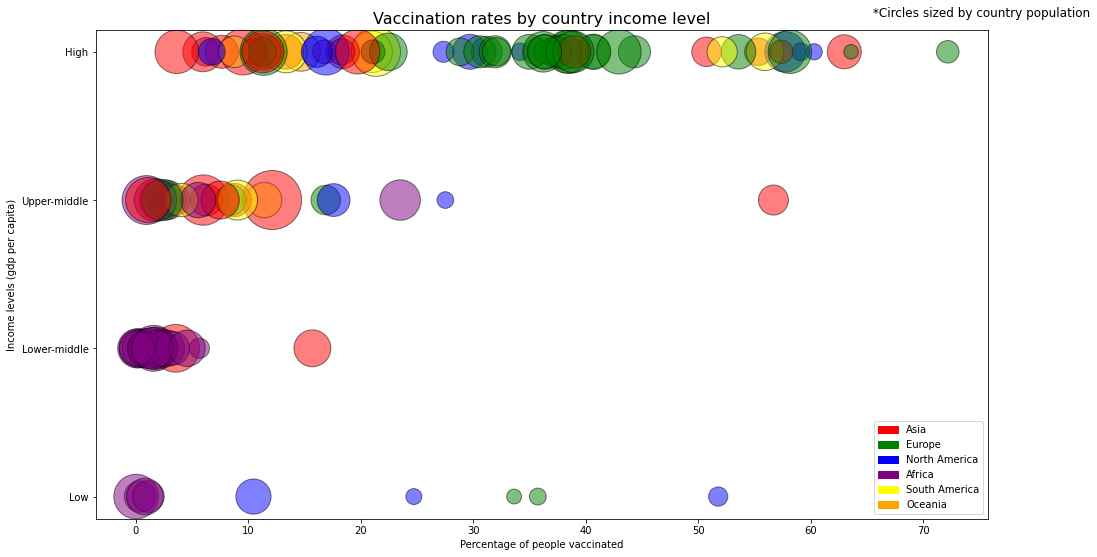

In [ ]:
plt.figure(figsize=(16,9))

colors = {"Asia" : "red", "Europe" : "green", "North America" : "Blue", "Africa" : "purple", "South America" : "yellow", "Oceania" : "orange"}
data_continent = data[data['continent'].notna()]
pop = np.log10((data_continent["population"])) ** 4 / 2

data_continent["income_level"] = 0
for country in data_continent.index:
  if ((data_continent.loc[country]["gdp_per_capita"] >= 1026) & (data_continent.loc[country]["gdp_per_capita"] <= 3995)):
    data_continent.at[country, "income_level"] = 1
  elif ((data_continent.loc[country]["gdp_per_capita"] >= 3996) & (data_continent.loc[country]["gdp_per_capita"] <= 12375)):
    data_continent.at[country, "income_level"] = 2
  elif ((data_continent.loc[country]["gdp_per_capita"] >= 12376)):
    data_continent.at[country, "income_level"] = 3

plt.scatter(data_continent["people_vaccinated_per_hundred"], data_continent["income_level"], s = pop,  
            c = data_continent["continent"].map(colors), edgecolors='k', alpha = 0.5)
plt.xlabel("Percentage of people vaccinated")
plt.ylabel("Income levels (gdp per capita)")
plt.title("Vaccination rates by country income level", fontsize=16)
pop = []
for continent in colors.keys():
  pop.append(mpatches.Patch(color=colors[continent], label=continent))
plt.legend(handles=pop)

income_levels = ["Low", "Lower-middle", "Upper-middle", "High"]
plt.yticks(range(len(income_levels)), income_levels)
plt.figtext(0.8,0.9,'*Circles sized by country population',fontsize=12,ha='left')

plt.show()

## Vaccinations in different age groups

The following cell gives us some information about vaccinations in some age ranges, specifically 18-24, 25-49, 50-59, 60-69, 70-79 and 80+ years old. We've present a graph with two variables, percentage of people with atleast one dose, and percentage of fully vaccinated people.

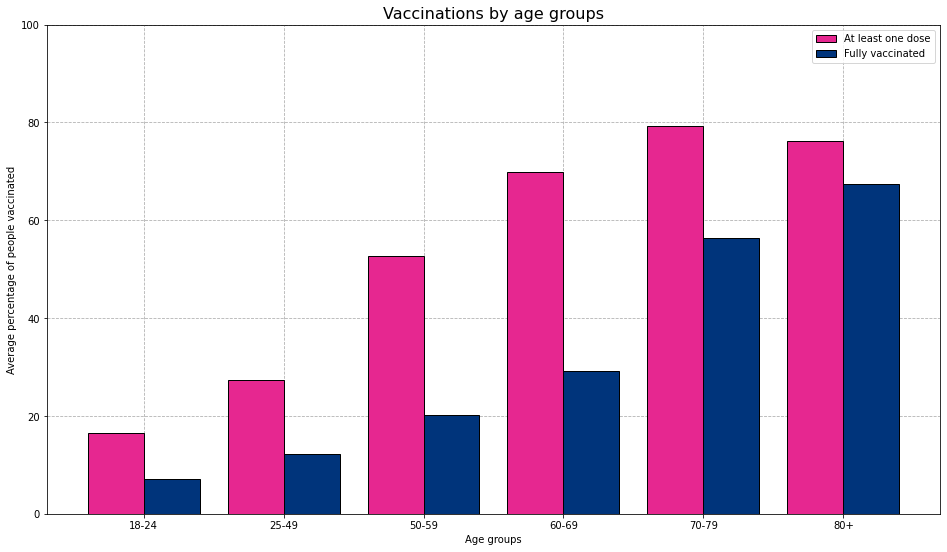

In [ ]:
age_groups = ["18-24", "25-49", "50-59", "60-69", "70-79", "80+"]
data_vaccinations_by_age = [["18-24", 0], ["25-49", 0], ["50-59", 0], ["60-69", 0], ["70-79", 0], ["80+", 0]]
data_vaccinations_by_age_fully = [["18-24", 0], ["25-49", 0], ["50-59", 0], ["60-69", 0], ["70-79", 0], ["80+", 0]]

for i in range(6):
  data_vaccinations_by_age[i][1] = data_vaccinations_by_age_group[data_vaccinations_by_age_group["age_group"] == age_groups[i]]["people_vaccinated_per_hundred"].mean()
  data_vaccinations_by_age_fully[i][1] = data_vaccinations_by_age_group[data_vaccinations_by_age_group["age_group"] == age_groups[i]]["people_fully_vaccinated_per_hundred"].mean()

data_vaccinations_by_age = pd.DataFrame(data_vaccinations_by_age, columns = ["age_groups", "average"])
data_vaccinations_by_age_fully = pd.DataFrame(data_vaccinations_by_age_fully, columns = ["age_groups", "average"])

n=6
r = np.arange(n)
width = 0.4

plt.figure(figsize=(16,9))
plt.bar(r, data_vaccinations_by_age["average"], color='#e62790',
        width = width, edgecolor = 'black',
        label='At least one dose', zorder=5)
plt.bar(r + width, data_vaccinations_by_age_fully["average"], color='#00347b',
        width = width, edgecolor = 'black',
        label='Fully vaccinated', zorder=5)
  
plt.xlabel("Age groups")
plt.ylabel("Average percentage of people vaccinated")
plt.title("Vaccinations by age groups", fontsize=16)
plt.ylim(0, 100)
plt.grid(linestyle='--', zorder=0)
plt.xticks(r + width/2, age_groups)
plt.legend()

plt.show()

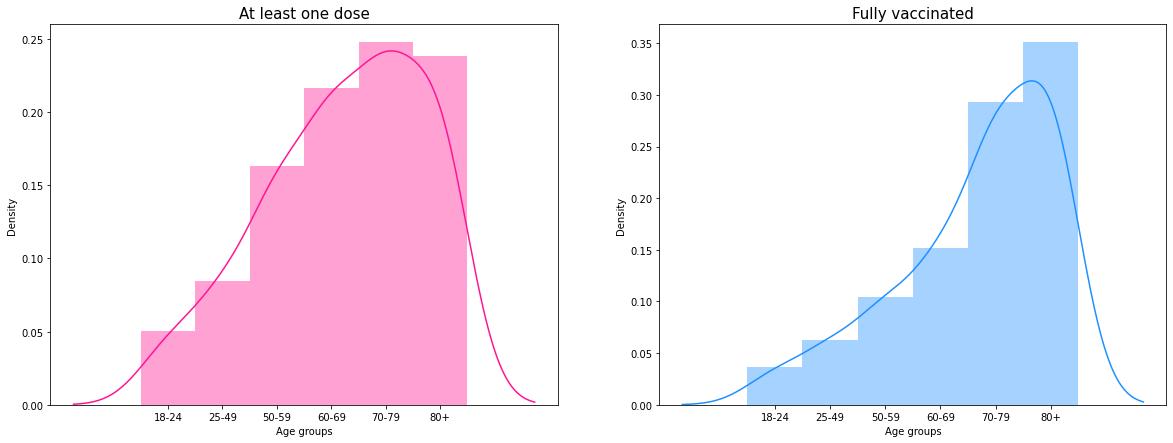

In [ ]:
colors = ["deeppink", "dodgerblue"]

data_vaccinations_by_age_test = []
data_vaccinations_by_age_fully_test = []

for age in range(len(age_groups)):
  for i in range(int(data_vaccinations_by_age[data_vaccinations_by_age["age_groups"] == age_groups[age]]["average"]) * 1000):
    data_vaccinations_by_age_test.append(age)
  for i in range(int(data_vaccinations_by_age_fully[data_vaccinations_by_age_fully["age_groups"] == age_groups[age]]["average"]) * 1000):
    data_vaccinations_by_age_fully_test.append(age)

temp = [data_vaccinations_by_age_test, data_vaccinations_by_age_fully_test]

fig, axs = plt.subplots(1, 2, figsize = (20, 7))
for col in range(2):                                                                               ###############
  sns.distplot(temp[col], color=colors[col], label="Compact", ax = axs[col], kde_kws={'bw': 0.4}, # Sửa cái này #
               hist_kws={'rwidth': 10}, bins=[-0.5,0.5,1.5,2.5,3.5,4.5,5.5])                       ###############
  axs[col].set_title("At least one dose" if col == 0 else "Fully vaccinated", fontsize = 15)
  axs[col].set(xlabel='Age groups')
  axs[col].set_xticks(np.arange(6), minor=False)
  axs[col].set_xticklabels(age_groups, fontdict=None, minor=False)

#fig.suptitle('Distribution of vaccinated age', fontsize = 20, y=0.98)
plt.show()

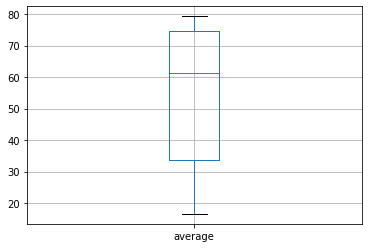

In [ ]:
data_vaccinations_by_age.boxplot()
#plt.title(label = 'Vaccinated age boxplot')

## Most widely-used type of vaccine in countries

The code cell below outputs a table with the most used type of vaccine in each country, along with its number of doses given. 

Due to the dataset's constrain, only 33 countries has been provided.

In [ ]:
vaccines_list = data_vaccinations_by_manufacturer["vaccine"].unique()
country_list = data_vaccinations_by_manufacturer["location"].unique()
data_vaccinations_by_manufacturer_popularity = pd.DataFrame()

for country in country_list:  
  latest_pref_date = max(data_vaccinations_by_manufacturer[data_vaccinations_by_manufacturer["location"] == country]["date"])
  latest_pref_vaccinations = max(data_vaccinations_by_manufacturer[data_vaccinations_by_manufacturer["location"] == country]["total_vaccinations"])
  data_vaccinations_by_manufacturer_popularity = data_vaccinations_by_manufacturer_popularity.append(data_vaccinations_by_manufacturer.loc[
     (data_vaccinations_by_manufacturer["date"] == latest_pref_date)
   & (data_vaccinations_by_manufacturer["location"] == country)
   & (data_vaccinations_by_manufacturer["total_vaccinations"] == latest_pref_vaccinations)])
data_vaccinations_by_manufacturer_popularity = data_vaccinations_by_manufacturer_popularity[["location", "vaccine", "total_vaccinations"]].reset_index(drop=True)
data_vaccinations_by_manufacturer_popularity.columns = ['Country', 'Most widely-used vaccine', 'Total vaccinations']
print(tabulate(data_vaccinations_by_manufacturer_popularity, headers='keys', tablefmt='psql'))

+----+---------------+----------------------------+----------------------+
|    | Country       | Most widely-used vaccine   |   Total vaccinations |
|----+---------------+----------------------------+----------------------|
|  0 | Austria       | Pfizer/BioNTech            |              3601904 |
|  1 | Belgium       | Pfizer/BioNTech            |              4611173 |
|  2 | Bulgaria      | Pfizer/BioNTech            |               754371 |
|  3 | Chile         | Sinovac                    |             15063947 |
|  4 | Croatia       | Pfizer/BioNTech            |              1187958 |
|  5 | Cyprus        | Pfizer/BioNTech            |               373057 |
|  6 | Czechia       | Pfizer/BioNTech            |              4276222 |
|  7 | Denmark       | Pfizer/BioNTech            |              2945791 |
|  8 | Estonia       | Pfizer/BioNTech            |               459539 |
|  9 | Finland       | Pfizer/BioNTech            |              2301437 |
| 10 | France        | Pf

## Number of doses given of each type of vaccine

The following code cell gives us stats about each type of vaccine's doses given. Eight mains vaccine manufacturers have been inspected, namely Johnson & Johnson, Moderna, Oxford/AstraZeneca, Pfizer/BioNTech, Sinovac, CanSino, Sputnik V and Sinopharm/Beijing.

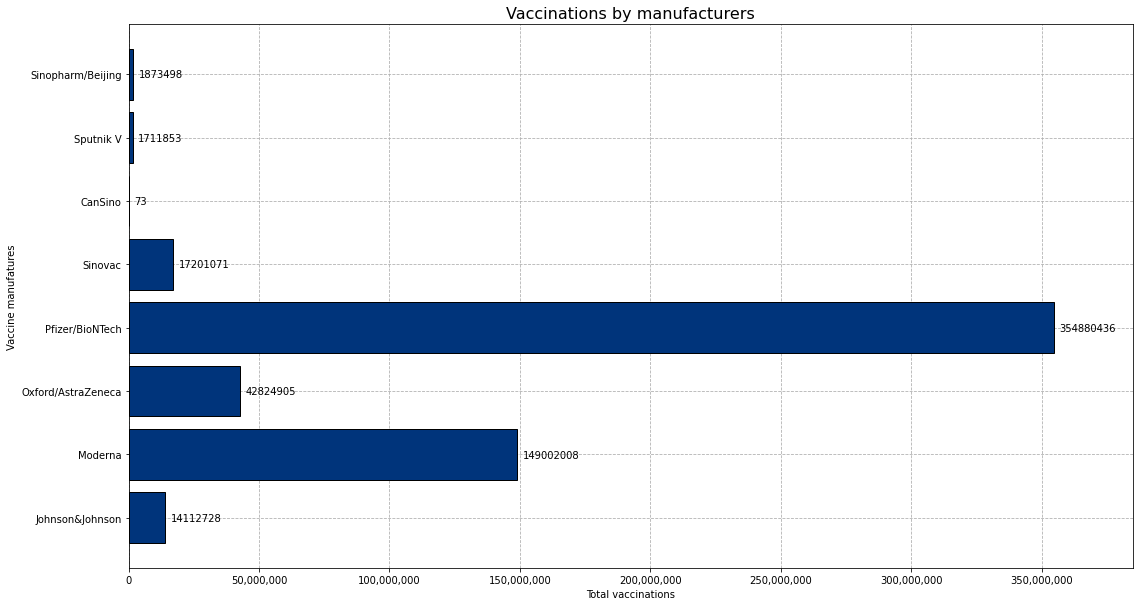

In [ ]:
data_vaccinations_by_manufacturer_total_doses = []
data_vaccinations_by_manufacturer_total_doses_raw = pd.DataFrame()
for country in country_list:  
  latest_pref_date = max(data_vaccinations_by_manufacturer[data_vaccinations_by_manufacturer["location"] == country]["date"])
  data_vaccinations_by_manufacturer_total_doses_raw = data_vaccinations_by_manufacturer_total_doses_raw.append(data_vaccinations_by_manufacturer.loc[
     (data_vaccinations_by_manufacturer["date"] == latest_pref_date)
   & (data_vaccinations_by_manufacturer["location"] == country)])

for vaccine in vaccines_list:
  data_vaccinations_by_manufacturer_total_doses.append([str(vaccine), int(data_vaccinations_by_manufacturer_total_doses_raw[data_vaccinations_by_manufacturer_total_doses_raw["vaccine"] == vaccine]["total_vaccinations"].sum())])
data_vaccinations_by_manufacturer_total_doses  = pd.DataFrame(data_vaccinations_by_manufacturer_total_doses, columns=["vaccine", "total_vaccinations"])

f, ax = plt.subplots(figsize=(18,10))

plt.barh(data_vaccinations_by_manufacturer_total_doses["vaccine"], data_vaccinations_by_manufacturer_total_doses["total_vaccinations"],
        color='#00347b', edgecolor = 'black', zorder=5)

plt.xlabel("Total vaccinations")
plt.ylabel("Vaccine manufatures")
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.grid(linestyle='--', zorder=0)
plt.xlim(0, 3.85e8)
for i, v in enumerate(data_vaccinations_by_manufacturer_total_doses["total_vaccinations"]):
    ax.text(v + 2e6, i - 0.05, str(v))
plt.title("Vaccinations by manufacturers", fontsize=16)

plt.show()

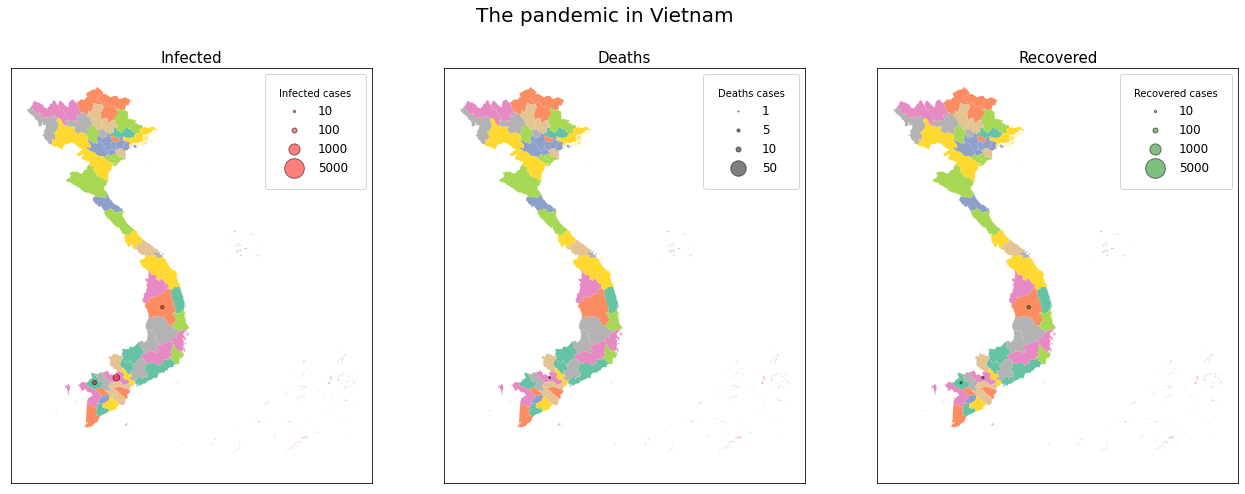

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (22, 8))
fig.suptitle('The pandemic in Vietnam', fontsize = 20, y=0.97)
labels = [[10, 100, 1000, 5000], [1, 5, 10, 50]]

properties = [["Infected", "r"], ["Deaths", "black"], ["Recovered", "green"]]

for i in range(3):
  axs[i] = provinces.plot(column = 'ten_tinh', cmap = 'Set2', ax=axs[i])
  scale = 0.7 if i != 1 else 1.4
  axs[i].scatter(df.long, df.lat, s=df[properties[i][0]] ** scale, alpha=0.5, edgecolor='black', c=properties[i][1])
  axs[i].set_title(string.capwords(properties[i][0]), fontsize = 15)
  axs[i].axes.get_xaxis().set_visible(False)
  axs[i].axes.get_yaxis().set_visible(False)
  l = []
  for j in range(len(labels[0 if i != 1 else 1])):
    l.append(plt.scatter([],[], s=labels[0 if i != 1 else 1][j] ** scale, alpha=0.5, edgecolor='black', c=properties[i][1]))
  axs[i].legend(l, labels[0 if i != 1 else 1], frameon=True, fontsize=12,
  handlelength=2, loc = 1, borderpad = 1.2,
  handletextpad=1, title=string.capwords(properties[i][0]) + ' cases', scatterpoints = 1)

plt.show()